### Clasificacion nivel de fuerza muscular (Escala de Daniels) 

Tomando los datos antropométricos de la poblacion colombiana, los rangos de movilidad de la articulacion superior en todos los planos y la cantidad de peso maximo que soporta el paciente sin usar el otro brazo, se desea realizar una aproximacion de la escala de Daniels que especifica los niveles de fuerza muscular.

las muestras poblacionales son de personas entre los 20 y 59 años.

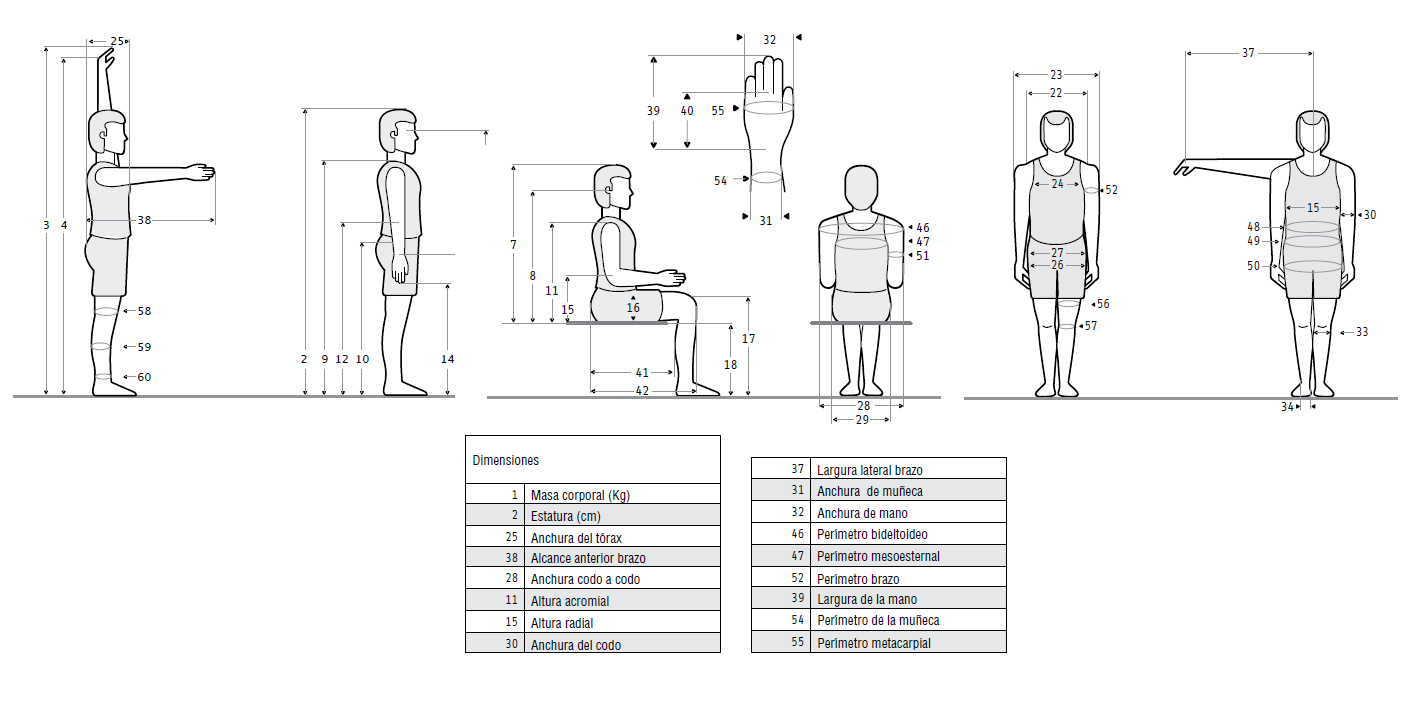

La fuerza muscular es un parametro subjetivo y dificil de calcular, la escala de Daniels permite valorar el esfuerzo muscular de forma mas objetiva para determinar el proceso de recuperacion de un paciente, pero no es precisa

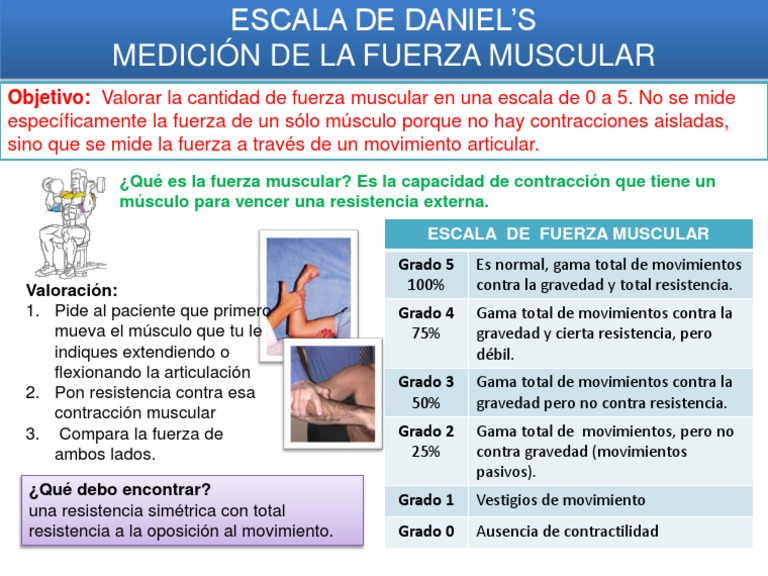

### Desarrollo de la red neruronal para clasificacion de esfuerzo muscular (Daniels)

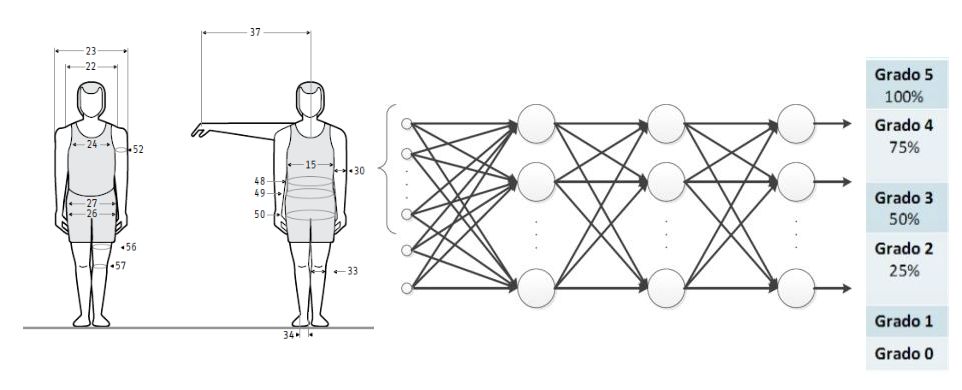

In [ ]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Mostrar el resultado de cada linea de la misma celda

# importar librerias 
import numpy as np
import pandas as pd
import tensorflow
import tensorflow.keras as keras

#importar caracteristicas de librerias
from matplotlib import colors
from keras.layers import Dense
from keras.models import Sequential 
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, SelectFpr
from sklearn.preprocessing import scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from scipy.stats import randint
import tensorflow as tf

from keras.regularizers import l2, l1, l1_l2
from keras.layers import Dropout
from keras import backend as K
from matplotlib import pyplot
from pandas import DataFrame
import time

In [ ]:
Pacientes=pd.read_excel('DatosEntrada.xlsx') # Importar valores de entrada
Pacientes.head() # Imprimir las primeras 5 filas
Pacientes.shape # Imprimir el tamaño de datos

In [ ]:
Pacientes.info() # Imprimir data frame (revisar que no hay valores nulos)
print('__________________________________________________')

In [ ]:
Pacientes.describe() # Imprimir descripcion de datos estaditicos basicos
pd.isnull(Pacientes).sum() # checkear si hay valores nulos

In [ ]:
Fuerza=round(pd.read_excel('DatosSalida.xlsx')) # Importar valores de salida y redondear valores
Fuerza.head() # Imprimir las primeras 5 filas
Fuerza.shape # Imprimir el tamaño de datos

In [ ]:
Diagnostico = pd.concat([Pacientes,Fuerza], sort=False, axis=1) # Concatenar los datos de Fuerza en los datos de Pacientes
Diagnostico.sample(10)

print('Observations per class: \n', Diagnostico['Danields'].value_counts())

In [ ]:
from sklearn.preprocessing import StandardScaler

x = Diagnostico.drop('Danields', axis=1) # Guardar valores de entrada en x
y = Diagnostico.Danields # Guardar valores de salida en y 

x = StandardScaler().fit_transform(x) # Scale the data with `StandardScaler`


### Comparacion de optimizacion

In [ ]:
# grid search values

sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
rms = keras.optimizers.RMSprop(lr=0.01, rho=0.9)
adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adamax = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
nadam = keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

values = [sgd, rms, adagrad, adadelta, adam, adamax, nadam]
all_train, all_test = list(), list()
list1_history = []
list1_y_pred = []
list1_y_test = []
list1_time = []
list1_r2 = []


for param in values:
    
    import time
    start_time = time.time()
    seed = 7
    np.random.seed(seed)    
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train, test in kfold.split(x, y):
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=param, loss='mse', metrics=['accuracy'])
        history=model.fit(x[train], y[train], epochs=50, verbose=0, validation_data=(x[test], y[test]))
        
    list1_history.append(history)
    print("--- %s seconds ---" % (time.time() - start_time))
    time = time.time() - start_time
    list1_time.append(time)
    
    
    y_pred = model.predict(x[test]).round()
    y_test = y[test]
    list1_y_pred.append(y_pred)
    list1_y_test.append(y_test)
    
    mse_value, mae_value = model.evaluate(x[test], y[test], verbose=1)
    print("Error cuadrado medio: "+" "+str(mse_value))
    print("Error absoluto medio: "+" "+str(mae_value))
    print("R2: "+" "+ str(r2_score(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    list1_r2.append(r2)
    
    # reset states
    model.reset_states() 
    del model
    

K.clear_session()
print(list1_history[0].history.keys())

    

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

import matplotlib.pyplot as plt
import numpy as np

list1_y_pred = np.array(list1_y_pred)
list1_y_test = np.array(list1_y_test)


f = plt.figure()    
f, axes = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey = True)
axes[0][0].scatter(range(len(list1_y_test[0,:])),list1_y_test[0,:], c = "r" )
axes[0][0].scatter(range(len(list1_y_pred[0,:])),list1_y_pred[0,:], c = "b", marker = 'x')
axes[0][0].set_xlabel('SGD', labelpad = 5)

axes[0][1].scatter(range(len(list1_y_test[1,:])),list1_y_test[1,:], c = "r" )
axes[0][1].scatter(range(len(list1_y_pred[1,:])),list1_y_pred[1,:], c = "b", marker = 'x')
axes[0][1].set_xlabel('RMSProp', labelpad = 5)

axes[1][0].scatter(range(len(list1_y_test[2,:])),list1_y_test[2,:], c = "r" )
axes[1][0].scatter(range(len(list1_y_pred[2,:])),list1_y_pred[2,:], c = "b", marker = 'x')
axes[1][0].set_xlabel('Adragrad', labelpad = 5)

axes[1][1].scatter(range(len(list1_y_test[3,:])),list1_y_test[3,:], c = "r" )
axes[1][1].scatter(range(len(list1_y_pred[3,:])),list1_y_pred[3,:], c = "b", marker = 'x')
axes[1][1].set_xlabel('Adadelta', labelpad = 5)

axes[2][0].scatter(range(len(list1_y_test[4,:])),list1_y_test[4,:], c = "r" )
axes[2][0].scatter(range(len(list1_y_pred[4,:])),list1_y_pred[4,:], c = "b", marker = 'x')
axes[2][0].set_xlabel('Adam', labelpad = 5)

axes[2][1].scatter(range(len(list1_y_test[5,:])),list1_y_test[5,:], c = "r" )
axes[2][1].scatter(range(len(list1_y_pred[5,:])),list1_y_pred[5,:], c = "b", marker = 'x')
axes[2][1].set_xlabel('Adamax', labelpad = 5)

axes[3][0].scatter(range(len(list1_y_test[6,:])),list1_y_test[6,:], c = "r" )
axes[3][0].scatter(range(len(list1_y_pred[6,:])),list1_y_pred[6,:], c = "b", marker = 'x')
axes[3][0].set_xlabel('Nadam', labelpad = 5)

plt.show()


In [ ]:
print(list1_history[0].history.keys())

plt.figure(figsize=[12, 7],dpi=90)

#  "Accuracy"
plt.plot(list1_history[0].history['accuracy'], color='blue', label='SGD (train)')
plt.plot(list1_history[0].history['val_accuracy'],'--', color='blue', alpha=0.6, label='SGD (test)')

plt.plot(list1_history[1].history['accuracy'], color='red', label='RMSprop (train)')
plt.plot(list1_history[1].history['val_accuracy'],'--', color='red', alpha=0.6, label='RMSprop (test)')

plt.plot(list1_history[2].history['accuracy'], color='yellow', label='Adragrad (train)')
plt.plot(list1_history[2].history['val_accuracy'],'--', color='yellow', alpha=0.6, label='Adagrad (test)')

plt.plot(list1_history[3].history['accuracy'], color='black', label='Adadelta (train)')
plt.plot(list1_history[3].history['val_accuracy'],'--', color='black', alpha=0.6, label='Adadelta (test)')

plt.plot(list1_history[4].history['accuracy'], color='gray', label='Adam (train)')
plt.plot(list1_history[4].history['val_accuracy'],'--', color='gray', alpha=0.6, label='Adam (test)')

plt.plot(list1_history[5].history['accuracy'], color='green', label='Adamax (train)')
plt.plot(list1_history[5].history['val_accuracy'],'--', color='green', alpha=0.6, label='Adamax (test)')

plt.plot(list1_history[6].history['accuracy'], color='orange', label='Nadam (train)')
plt.plot(list1_history[6].history['val_accuracy'],'--', color='orange', alpha=0.6, label='Nadam (test)')

plt.axes().set(xlim=(-1, 50), ylim=(0, 1.2))

plt.title('Accuracy vs epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(axis='y')
plt.legend(title='Accuracy curves')
plt.show()



In [ ]:
plt.figure(figsize=[12, 7],dpi=90)

plt.plot(list1_history[0].history['loss'], color='blue', label='SGD (train)')
plt.plot(list1_history[0].history['val_loss'],'--', color='blue', alpha=0.6, label='SGD (test)')

plt.plot(list1_history[1].history['loss'], color='red', label='RMSprop (train)')
plt.plot(list1_history[1].history['val_loss'],'--', color='red', alpha=0.6, label='RMSprop (test)')

plt.plot(list1_history[2].history['loss'], color='yellow', label='Adragrad (train)')
plt.plot(list1_history[2].history['val_loss'],'--', color='yellow', alpha=0.6, label='Adagrad (test)')

plt.plot(list1_history[3].history['loss'], color='black', label='Adadelta (train)')
plt.plot(list1_history[3].history['val_loss'],'--', color='black', alpha=0.6, label='Adadelta (test)')

plt.plot(list1_history[4].history['loss'], color='gray', label='Adam (train)')
plt.plot(list1_history[4].history['val_loss'],'--', color='gray', alpha=0.6, label='Adam (test)')

plt.plot(list1_history[5].history['loss'], color='green', label='Adamax (train)')
plt.plot(list1_history[5].history['val_loss'],'--', color='green', alpha=0.6, label='Adamax (test)')

plt.plot(list1_history[6].history['loss'], color='orange', label='Nadam (train)')
plt.plot(list1_history[6].history['val_loss'],'--', color='orange', alpha=0.6, label='Nadam (test)')

plt.axes().set(xlim=(-1, 50), ylim=(0, 3))

plt.title('Loss vs epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(axis='y')
plt.legend(title='Loss curves')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,1,1])
opt = ['SGD', 'RMS', 'Adragrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
students = [list1_r2[0],list1_r2[1],list1_r2[2],list1_r2[3],list1_r2[4],list1_r2[5],list1_r2[6]]
ax.bar(opt,students)

plt.title('R2')
plt.ylabel('R2')
plt.xlabel('Optimizer')
plt.show()

### Comparacion funciones de perdida

**MSE**

In [ ]:
# grid search values

mse = keras.losses.mean_squared_error
mae = keras.losses.mean_absolute_error
rmsle = keras.losses.mean_squared_logarithmic_error
hs = keras.losses.squared_hinge
h = keras.losses.categorical_hinge
logcosh = keras.losses.logcosh
cp = keras.losses.cosine_proximity

values = [mse, mae, rmsle, hs, h, logcosh, cp]
all_train, all_test = list(), list()
list2_history = []
list2_y_pred = []
list2_y_test = []
list2_time = []
list2_r2 = []


for param in values:
    
    import time
    start_time = time.time()
    seed = 7
    np.random.seed(seed)    
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train, test in kfold.split(x, y):
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        model.compile(optimizer=sgd, loss=param, metrics=['accuracy'])
        history=model.fit(x[train], y[train], epochs=50, verbose=0, validation_data=(x[test], y[test]))
        
    list2_history.append(history)
    print("--- %s seconds ---" % (time.time() - start_time))
    time = time.time() - start_time
    list2_time.append(time)
    
    
    y_pred = model.predict(x[test]).round()
    y_test = y[test]
    list2_y_pred.append(y_pred)
    list2_y_test.append(y_test)
    
    mse_value, mae_value = model.evaluate(x[test], y[test], verbose=1)
    print("Error cuadrado medio: "+" "+str(mse_value))
    print("Error absoluto medio: "+" "+str(mae_value))
    print("R2: "+" "+ str(r2_score(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    list2_r2.append(r2)
    
    # reset states
    model.reset_states() 
    del model
    

K.clear_session()
print(list2_history[0].history.keys())

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

import matplotlib.pyplot as plt
import numpy as np

list2_y_pred = np.array(list2_y_pred)
list2_y_test = np.array(list2_y_test)


f = plt.figure()    
f, axes = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey = True)
axes[0][0].scatter(range(len(list2_y_test[0,:])),list2_y_test[0,:], c = "r" )
axes[0][0].scatter(range(len(list2_y_pred[0,:])),list2_y_pred[0,:], c = "b", marker = 'x')
axes[0][0].set_xlabel('MSE', labelpad = 5)

axes[0][1].scatter(range(len(list2_y_test[1,:])),list2_y_test[1,:], c = "r" )
axes[0][1].scatter(range(len(list2_y_pred[1,:])),list2_y_pred[1,:], c = "b", marker = 'x')
axes[0][1].set_xlabel('MAE', labelpad = 5)

axes[1][0].scatter(range(len(list2_y_test[2,:])),list2_y_test[2,:], c = "r" )
axes[1][0].scatter(range(len(list2_y_pred[2,:])),list2_y_pred[2,:], c = "b", marker = 'x')
axes[1][0].set_xlabel('RMSLE', labelpad = 5)

axes[1][1].scatter(range(len(list2_y_test[3,:])),list2_y_test[3,:], c = "r" )
axes[1][1].scatter(range(len(list2_y_pred[3,:])),list2_y_pred[3,:], c = "b", marker = 'x')
axes[1][1].set_xlabel('Hinge Square', labelpad = 5)

axes[2][0].scatter(range(len(list2_y_test[4,:])),list2_y_test[4,:], c = "r" )
axes[2][0].scatter(range(len(list2_y_pred[4,:])),list2_y_pred[4,:], c = "b", marker = 'x')
axes[2][0].set_xlabel('Hinge', labelpad = 5)

axes[2][1].scatter(range(len(list2_y_test[5,:])),list2_y_test[5,:], c = "r" )
axes[2][1].scatter(range(len(list2_y_pred[5,:])),list2_y_pred[5,:], c = "b", marker = 'x')
axes[2][1].set_xlabel('Logcosh', labelpad = 5)

axes[3][0].scatter(range(len(list2_y_test[6,:])),list2_y_test[6,:], c = "r" )
axes[3][0].scatter(range(len(list2_y_pred[6,:])),list2_y_pred[6,:], c = "b", marker = 'x')
axes[3][0].set_xlabel('Cosine proximity', labelpad = 5)

plt.show()

In [ ]:
print(list2_history[0].history.keys())

plt.figure(figsize=[12, 7],dpi=90)

#  "Accuracy"
plt.plot(list2_history[0].history['accuracy'], color='blue', label='MSE (train)')
plt.plot(list2_history[0].history['val_accuracy'],'--', color='blue', alpha=0.6, label='MSE (test)')

plt.plot(list2_history[1].history['accuracy'], color='red', label='MAE (train)')
plt.plot(list2_history[1].history['val_accuracy'],'--', color='red', alpha=0.6, label='MAE (test)')

plt.plot(list2_history[2].history['accuracy'], color='yellow', label='RMSLE (train)')
plt.plot(list2_history[2].history['val_accuracy'],'--', color='yellow', alpha=0.6, label='RMSLE (test)')

plt.plot(list2_history[3].history['accuracy'], color='black', label='Hinge square (train)')
plt.plot(list2_history[3].history['val_accuracy'],'--', color='black', alpha=0.6, label='Hinge square (test)')

plt.plot(list2_history[4].history['accuracy'], color='gray', label='Hinge (train)')
plt.plot(list2_history[4].history['val_accuracy'],'--', color='gray', alpha=0.6, label='Hinge (test)')

plt.plot(list2_history[5].history['accuracy'], color='green', label='Logcosh (train)')
plt.plot(list2_history[5].history['val_accuracy'],'--', color='green', alpha=0.6, label='Logcosh (test)')

plt.plot(list2_history[6].history['accuracy'], color='orange', label='Cosine proximity (train)')
plt.plot(list2_history[6].history['val_accuracy'],'--', color='orange', alpha=0.6, label='Cosine proximity (test)')

plt.axes().set(xlim=(-1, 50), ylim=(0, 1.1))

plt.title('Accuracy vs epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(axis='y')
plt.legend(title='Accuracy curves')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,1,1])
opt = ['mse', 'mae', 'rmsle', 'hinge square', 'hinge', 'logcosh', 'cosine proximity']
students = [list2_r2[0],list2_r2[1],list2_r2[2],list2_r2[3],list2_r2[4],list2_r2[5],list2_r2[6]]
ax.bar(opt,students)

plt.title('R2')
plt.ylabel('R2')
plt.xlabel('Loss function')
plt.show()

### Comparacion Regularizadores

In [ ]:
from keras import regularizers
from keras.callbacks import EarlyStopping
# grid search values

values = ['a','b','c','d','e']
all_train, all_test = list(), list()
list3_history = []
list3_y_pred = []
list3_y_test = []
list3_time = []
list3_r2 = []

def L1():
    model.add(Dense(256, activation='relu', activity_regularizer=l1(0.001)))
    model.add(Dense(1))
    sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    return (es)

def L2():
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1))
    sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    return (es)

def L12():
    model.add(Dense(256, activation='relu', bias_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
    model.add(Dense(1))
    sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    return (es)

def Dropout():
    from keras.layers import Dropout
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    return (es)
              
def Early():
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    sgd= keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    return (es)

functions = {'a': L1,
             'b': L2,
             'c': L12,
             'd': Dropout,
             'e': Early}

for param in values:
    
    import time
    start_time = time.time()
    seed = 7
    np.random.seed(seed)    
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train, test in kfold.split(x, y):
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        func = functions[param]
        es = func()
        history=model.fit(x[train], y[train], epochs=50, verbose=0, validation_data=(x[test], y[test]),callbacks=[es])
        
    list3_history.append(history)
    print("--- %s seconds ---" % (time.time() - start_time))
    time = time.time() - start_time
    list3_time.append(time)
    

    y_pred = model.predict(x[test]).round()
    y_test = y[test]
    list3_y_pred.append(y_pred)
    list3_y_test.append(y_test)
    
    mse_value, mae_value = model.evaluate(x[test], y[test], verbose=1)
    print("Error cuadrado medio: "+" "+str(mse_value))
    print("Error absoluto medio: "+" "+str(mae_value))
    print("R2: "+" "+ str(r2_score(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    list3_r2.append(r2)
    
    # reset states
    model.reset_states() 
    del model
    

K.clear_session()
print(list3_history[0].history.keys())

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

import matplotlib.pyplot as plt
import numpy as np

list3_y_pred = np.array(list3_y_pred)
list3_y_test = np.array(list3_y_test)


f = plt.figure()    
f, axes = plt.subplots(nrows = 3, ncols = 2, sharex=True, sharey = True)
axes[0][0].scatter(range(len(list3_y_test[0,:])),list3_y_test[0,:], c = "r" )
axes[0][0].scatter(range(len(list3_y_pred[0,:])),list3_y_pred[0,:], c = "b", marker = 'x')
axes[0][0].set_xlabel('L1', labelpad = 5)

axes[0][1].scatter(range(len(list3_y_test[1,:])),list3_y_test[1,:], c = "r" )
axes[0][1].scatter(range(len(list3_y_pred[1,:])),list3_y_pred[1,:], c = "b", marker = 'x')
axes[0][1].set_xlabel('L2', labelpad = 5)

axes[1][0].scatter(range(len(list3_y_test[2,:])),list3_y_test[2,:], c = "r" )
axes[1][0].scatter(range(len(list3_y_pred[2,:])),list3_y_pred[2,:], c = "b", marker = 'x')
axes[1][0].set_xlabel('L1 y L2', labelpad = 5)

axes[1][1].scatter(range(len(list3_y_test[3,:])),list3_y_test[3,:], c = "r" )
axes[1][1].scatter(range(len(list3_y_pred[3,:])),list3_y_pred[3,:], c = "b", marker = 'x')
axes[1][1].set_xlabel('Dropout', labelpad = 5)

axes[2][0].scatter(range(len(list3_y_test[4,:])),list3_y_test[4,:], c = "r" )
axes[2][0].scatter(range(len(list3_y_pred[4,:])),list3_y_pred[4,:], c = "b", marker = 'x')
axes[2][0].set_xlabel('Early Stopping', labelpad = 5)


plt.show()

In [ ]:
print(list3_history[0].history.keys())

plt.figure(figsize=[12, 7],dpi=90)

#  "Accuracy"
plt.plot(list3_history[0].history['accuracy'], color='blue', label='L1 (train)')
plt.plot(list3_history[0].history['val_accuracy'],'--', color='blue', alpha=0.6, label='L1 (test)')

plt.plot(list3_history[1].history['accuracy'], color='red', label='L2 (train)')
plt.plot(list3_history[1].history['val_accuracy'],'--', color='red', alpha=0.6, label='L2 (test)')

plt.plot(list3_history[2].history['accuracy'], color='yellow', label='L1 y L2 (train)')
plt.plot(list3_history[2].history['val_accuracy'],'--', color='yellow', alpha=0.6, label='L1 y L2 (test)')

plt.plot(list3_history[3].history['accuracy'], color='black', label='Dropout (train)')
plt.plot(list3_history[3].history['val_accuracy'],'--', color='black', alpha=0.6, label='Dropout (test)')

plt.plot(list3_history[4].history['accuracy'], color='green', label='Early Stopping (train)')
plt.plot(list3_history[4].history['val_accuracy'],'--', color='green', alpha=0.6, label='Early Stopping (test)')


plt.axes().set(xlim=(-1, 50), ylim=(0, 1.1))

plt.title('Accuracy vs epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(axis='y')
plt.legend(title='Accuracy curves')
plt.show()

In [ ]:
print(list3_history[0].history.keys())

plt.figure(figsize=[12, 7],dpi=90)

#  "Accuracy"
plt.plot(list3_history[0].history['loss'], color='blue', label='L1 (train)')
plt.plot(list3_history[0].history['val_loss'],'--', color='blue', alpha=0.6, label='L1 (test)')

plt.plot(list3_history[1].history['loss'], color='red', label='L2 (train)')
plt.plot(list3_history[1].history['val_loss'],'--', color='red', alpha=0.6, label='L2 (test)')

plt.plot(list3_history[2].history['loss'], color='yellow', label='L1 y L2 (train)')
plt.plot(list3_history[2].history['val_loss'],'--', color='yellow', alpha=0.6, label='L1 y L2 (test)')

plt.plot(list3_history[3].history['loss'], color='black', label='Dropout (train)')
plt.plot(list3_history[3].history['val_loss'],'--', color='black', alpha=0.6, label='Dropout (test)')

plt.plot(list3_history[4].history['loss'], color='gray', label='Early Stopping (train)')
plt.plot(list3_history[4].history['val_loss'],'--', color='gray', alpha=0.6, label='Early Stopping (test)')

plt.axes().set(xlim=(-1, 50), ylim=(0, 1.5))

plt.title('Loss vs epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(axis='y')
plt.legend(title='Loss curves')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,1,1])
opt = ['L1', 'L2', 'L1 y L2', 'Dropout', 'Early Stopping']
students = [list3_r2[0],list3_r2[1],list3_r2[2],list3_r2[3],list3_r2[4]]
ax.bar(opt,students)

plt.title('R2')
plt.ylabel('R2')
plt.xlabel('Loss function')
plt.show()

### Definición del párametro de regularización lambda

In [ ]:
import time
start_time = time.time()

seed = 7
np.random.seed(seed)

# grid search values
values = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4]
all_train, all_test = list(), list()
for param in values:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train, test in kfold.split(x, y):
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu', kernel_regularizer=l2(param)))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        sgd=SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
        history=model.fit(x[train], y[train], epochs=50, verbose=1, validation_data=(x[test], y[test]))
    # evaluate the model
    _, train_acc = model.evaluate(x[train], y[train], verbose=0)
    _, test_acc = model.evaluate(x[test], y[test], verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

print("--- %s seconds ---" % (time.time() - start_time))
time_r = time.time() - start_time

K.clear_session()

In [ ]:
# plot train and test means

plt.figure(figsize=[11, 6])
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Sigma vs Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sigma')
pyplot.show()

### Tunning de optimizadores usando Grid Search

In [ ]:

def create_model(optimizer='adam'):
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=1, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_+1, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = grid_result.predict(x[test]).round()
y_test = y[test]

print(grid_result.cv_results_.keys())


In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

## Tunning de optimizadores usando Random Search

In [ ]:
def create_model(optimizer='adam'):
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=1, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100,n_jobs=-1, cv=kfold)
rsearch_result = rsearch.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_+1, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = rsearch_result.predict(x[test]).round()
y_test = y[test]

print(rsearch_result.cv_results_.keys())


In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

In [ ]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,0.5,1])
opt = ['Grid Search (Adam)', 'Random Search (Adagrad)']
students = [grid_result.best_score_+1,rsearch_result.best_score_+1]
ax.bar(opt,students)

plt.title('Grid search vs random search')
plt.ylabel('Best score')
plt.show()

### Tunning de Batch size y Epoch usando Grid Search

In [ ]:
def create_model():
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_+1, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = grid_result.predict(x[test]).round()
y_test = y[test]

print(grid_result.cv_results_.keys())

### Tunning de Batch size y Epoch usando Random Search

In [ ]:
def create_model():
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=kfold)
rsearch_result = rsearch.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_+1, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = rsearch_result.predict(x[test]).round()
y_test = y[test]

print(rsearch_result.cv_results_.keys())

### Tunning de Learning rate usando Grid Search

In [ ]:
def create_model(learn_rate=0.01):
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.9)
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=1)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_+1, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = grid_result.predict(x[test]).round()
y_test = y[test]

print(grid_result.cv_results_.keys())

### Tunning de Learning rate usando Random Search

In [ ]:
def create_model(learn_rate=0.01):
    for train, test in kfold.split(x, y):
        # create model
        model = Sequential()
        model.add(Dense(128, input_dim=27, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.9)
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=1)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=kfold)
rsearch_result = rsearch.fit(x[train], y[train], validation_data=(x[test], y[test]))

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_+1, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean+1, stdev, param))
    
y_pred = rsearch_result.predict(x[test]).round()
y_test = y[test]

print(rsearch_result.cv_results_.keys())